# Image Processing (and Matplotlib)
Image processing is an extremely powerful tool for biomedical engineering. Did you know that in DNA sequencing image processing is used to make judgment calls for each individual base pair being A, T, C, or G? Image processing is also used in a variety of biomedical applications, like diagnosing cancerous tumors in images of tissue, image-guided surgery, and in numerous and disparate research applications.

In this module, we will explore a very simple image processing task: how to differentiate between handwritten 0's and 1's. While on the surface this task seems unrelated to biomedical engineering, a simple leap of imagination reveals that this kind of image processing could be used to differentiate (and thus diagnose) between bacilli and cocci. In other words, by learning how to process images of 0's and 1's, you are also learning how to develop a streptococci test!
![Image of Yaktocat](bacteria-shapes.png)


## 1. File Input, Loading Images, & Matplotlib
### Image Data and Format
The first thing we need to do in order to begin analyzing handwritten 0's and 1's, is to use Python to load a bunch of sample images of handwritten 0's and 1's. In the following code, we will be importing the two following files:
* `zeros.txt` contains 1000 images of 28 pixel x 28 pixel binary images of handwritten 0's
* `ones.txt`
contains 1000 images of 28 pixel x 28 pixel binary images of handwritten 1's

A **binary image** is an image that only has two possible values for each pixel, in this case 0 or 1. For this module, a pixel with value 0 will be white and a pixel with value 1 will be black (this is not always the case for image processing in general).

If you open the two text files, you will see that each file contains 1000 rows of 784 (28x28) 0 and 1's separated by spaces. Each of these rows corresponds to one 28x28 handwritten binary image. When we load the rows of 0 and 1's from these text files, we will need to "reshape" each row from a 1-dimentional 1x784 vector to a 28x28 sized 2-dimensional image. This is what the `reshape(1000, 28, 28)` function does in the code below.

After we have reshaped each image, we will be left with a final 1000x28x28 matrix of 0's and another 1000x28x28 matrix of 1's. This means that when we want to select the i'th image of the 0's, we can do so with the Python statement `zero[i-1, :, :]`. The `i-1` denotes the i'th image (because remember Python is 0-indexed!), and the colons denote that we want all 28 rows and 28 columns of the i'th image.

One artifact in our sample images is that they are rotated by 90 degrees, so we need to "unrotate" them by transposing each image after we import them.

### Matplotlib and Numpy
At the beginning of the code, you will see that we will be importing a couple of libraries to use in this module:
* `matplotlib` is a powerful Python plotting library that emulates plotting in MATLAB. This package will allow us to "plot" or show the imges of handwritten 0's and 1's. 
* `numpy` is a powerful Python library that allows us to use powerful functions with arrays and matrices




In [5]:
import numpy as np # import numpy
import matplotlib.pyplot as plt # import the plotting functionality of matplotlib
%matplotlib inline  # allows matplotlib plots to show up in Jupyter notebook

fname0 = 'zeros.txt' 
fname1 = 'ones.txt'
zeros = np.fromfile(fname0, dtype=np.int8, sep = ' ').reshape(1000, 28, 28) 
ones = np.fromfile(fname1, dtype=np.int8, sep=' ').reshape(1000, 28, 28)
for i in range(1000):
    # '.T' transposes each image matrix, i.e. rotates the images by 90 degrees
    zeros[i, :, :] = zeros[i, :, :].T 
    ones[i, :, :] = ones[i, :, :].T

### Viewing Images and Subplots
Now that we have loaded the image data into our matrix variables `zeros` and `ones`, let's see what a few of the handwritten images look like!

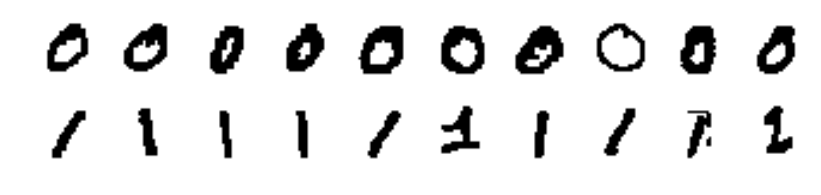

In [23]:
sample = 10 # how many sample images we want to see
plt.figure(figsize=(sample, 2)) # determines how big the images will be
for i in range(sample):
    plt.subplot(2, sample, i+1) # plots the next plot at location i+1 
    plt.imshow(zeros[i, :, :], cmap = matplotlib.cm.Greys), plt.axis('off')
    plt.subplot(2, sample, sample+i+1) # plots the next plot at location sample+i+1
    plt.imshow(ones[i, :, :], cmap = matplotlib.cm.Greys), plt.axis('off')

## 2. Initial Image Processing & Analysis
### Aggregate Image
Now that we have seen what a select few of the handwritten images look like, let's try to get a better understanding of what the data look like as a whole. To do this, we can simply sum all 1000 of the binary images together for each of 0 and 1. This in effect overlaying all 1000 images on top of each other and seeing what the aggregate image looks like. Remember that for each individual image, each pixel value can only be 0 or 1; however, if we sum all 1000 images together, each pixel value will range from 0 (if none of the 1000 images were black at that pixel) to 1000 (if all of the 1000 images were black at that pixel). This way, we can get an idea of which pixel locations in the 28x28 image are "popular" for the 0's and which ones are popular for the 1's. We will use the function `np.sum()`, which takes a matrix, and sums all the matrix entries along one of the dimensions (also known as axes). Since we have a 1000x28x28 matrix, and we want to sum all the 1000 images, we want to sum along the 1st axis (but remember that Python is 0-indexed, so this is really the 0th axis!). The code for this and the resulting "heatmap" images are shown below.

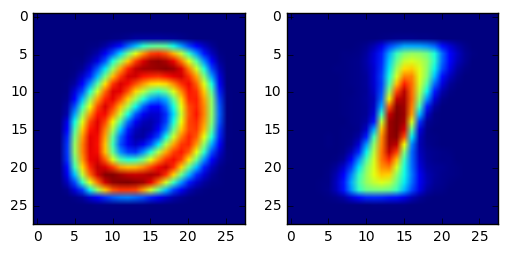

In [387]:
plt.subplot(1, 2, 1)
allzeros = np.sum(zeros, axis=0)
plt.imshow(allzeros)
plt.subplot(1, 2, 2)
allones = np.sum(ones, axis=0)
plt.imshow(allones);

### Discrimination Features
In order to perform the task of discriminating between a 0 and a 1, we need to figure out what makes an image of a 0 different than that of a 1. What differences do you notice between the aggregate 0 and the aggregate 1? Here are some that I noticed:
1. The 0's have many more pixels on average than the 1's (this is because a 0 is like the circumference of a circle, whereas a 1 is like the diameter of a circle, and we know that $circumference = \pi * diameter$
2. The middle of the 28x28 image is mostly empty for the 0's but filled for the 1's
3. The 0's are much "fatter" or wider in the middle around pixel row 15 than the 1's
4. The 0's have 90 degree rotational symmetry (if you rotate it by 90 degrees, it looks the same), while the 1's do not
5. The 0's have many pixels in the range `[10:15, 20:]` (middle right of the image), whereas the 1's have almost no pixels in that range

In image processing and "machine learning" in general, these differences that we have noted are commonly referred to as **features** of a classification task. We will explore each of these five features, and see which of the features will allow a computer to best discriminate between whether a random image is a 0 or 1 without actually looking at the image ourselves.

### 2.1 Total # of Black Pixels
Based on our first naive observation, that 0's tend to have more black pixels than 1's, let's try to analyze our data set of images and see how useful this feature is at discriminating between 0's and 1's. 

In order to do this, we simply have to store the total number (sum) of black pixels for each of the 1000 images of 0's and each of the 1000 images of 1's in separate lists, and then plot histograms of these sums. The code to do this is below:

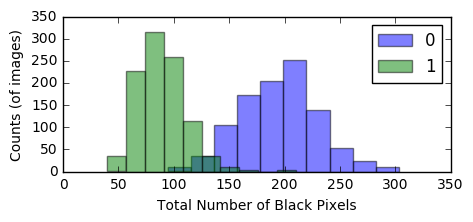

In [20]:
zeros_black = []
ones_black = []
for i in range(1000):
    zeros_black.append(np.sum(zeros[i, :, :]))
    ones_black.append(np.sum(ones[i, :, :]))
fig, ax = plt.subplots(figsize=(5, 2));
ax.hist(zeros_black, alpha = 0.5), ax.hist(ones_black, alpha = 0.5)
plt.legend(['0', '1']); plt.xlabel('Total Number of Black Pixels')
plt.ylabel('Counts (of images)');

Perhaps you remember our module on list comprehension, and notice that since `zeros_black` and `ones_black` are lists that are being populated with a `for` loop, we can actually simplify our code above and write them as list comprehensions! The code to do so is below:

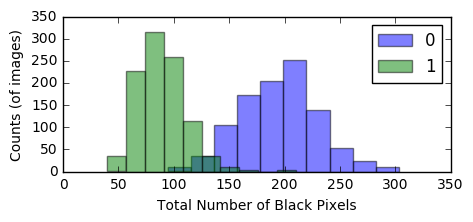

In [17]:
zeros_black = [np.sum(zeros[i, :, :]) for i in range(1000)]
ones_black = [np.sum(ones[i, :, :]) for i in range(1000)]
fig, ax = plt.subplots(figsize=(5, 2));
ax.hist(zeros_black, alpha = 0.5), ax.hist(ones_black, alpha = 0.5)
plt.legend(['0', '1']); plt.xlabel('Total Number of Black Pixels')
plt.ylabel('Counts (of images)');

As expected, we get the exact same result using the `for` loop as we do using list comprehensions, only that list comprehensions are more elegant. 

From the histogram, we can see that on average, the 0's have much higher total black pixels per image than the 1's do, as expected; however, in the range of ~100-160 total black pixels, the two histograms overlap. This means that for images with total black pixels in this range, it will be impossible to tell if they are 0's or 1's if we only look at the total number of black pixels. We can kind of tell that around 125 black pixels, there seems to be a decision boundary between the 0's and the 1's. Even so, if we choose 125 black pixels to be our boundary, a quick glance at the histogram tells us that we will incorrectly classify ~50 of the 0's as 1's and >50 of the 1's as 0's. This is around a 5% error rate for the discrimination task, which is a pretty high error rate if you're trying to diagnose if a patient has a bacilli or a cocci infection. Thus, we need to check of any of the other 4 features are more discriminating than the total number of black pixels.

### 2.2 Black Pixels in Center
We will now try to use a more refined feature, which was that the number of black pixels in the center of the image is much higher for 1's than for 0's (since 0 is shaped like a donut). Since the images are 28x28, the approximate region of the "middle" of the image will be around the 12-16th rows and the 12-16th columns. We will now try calling the same `np.sum()` function on the centers of all 1000 of the images and see if we can discriminate between the 0's and the 1's better.

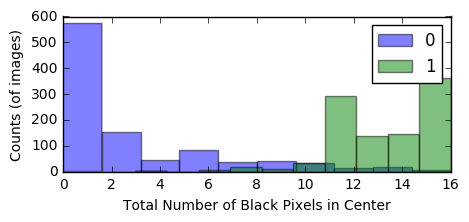

In [27]:
zeros_black = [np.sum(zeros[i, 12:16, 12:16]) for i in range(1000)]
ones_black = [np.sum(ones[i, 12:16, 12:16]) for i in range(1000)]
fig, ax = plt.subplots(figsize=(5, 2));
ax.hist(zeros_black, alpha = 0.5), ax.hist(ones_black, alpha = 0.5)
plt.legend(['0', '1']); plt.xlabel('Total Number of Black Pixels in Center')
plt.ylabel('Counts (of images)');

### 2.3 Width of the Middle

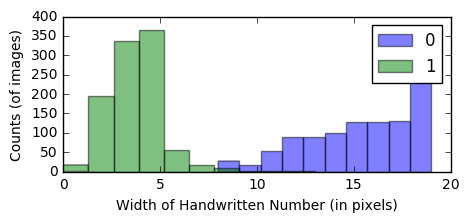

In [35]:
def width(image):
    return np.max(np.nonzero(image)) - np.min(np.nonzero(image))
width0 = [width(zeros[i, 12, :]) for i in range(1000)]
width1 = [width(ones[i, 12, :]) for i in range(1000)]
fig, ax = plt.subplots(figsize=(5, 2));
ax.hist(width0, alpha = 0.5), ax.hist(width1, alpha = 0.5)
plt.legend(['0', '1']); plt.xlabel('Width of Handwritten Number (in pixels)')
plt.ylabel('Counts (of images)');

### 2.4 Black Pixels in Center Right

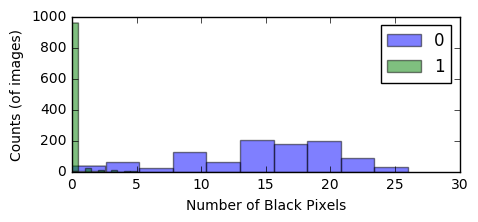

In [36]:
zavg = [np.sum(zeros[i, 10:15, 20:]) for i in range(1000)]
oavg = [np.sum(ones[i, 10:15, 20:]) for i in range(1000)]
fig, ax = plt.subplots(figsize=(5, 2))
ax.hist(zavg, alpha = 0.5), ax.hist(oavg, alpha = 0.5)
plt.legend(['0', '1']); plt.xlabel('Number of Black Pixels'); plt.ylabel('Counts (of images)');

### 2.5 Rotational Symmetry

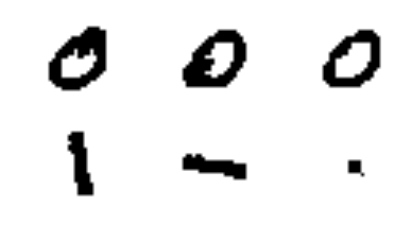

In [59]:
plt.set_cmap(matplotlib.cm.Greys)
plt.figure(figsize=(5, 2.5))
plt.subplot(2, 3, 1), plt.imshow(zeros[1, :, :]), plt.axis('off')
plt.subplot(2, 3, 2), plt.imshow(zeros[1, :, :].T), plt.axis('off')
plt.subplot(2, 3, 3), plt.imshow(zeros[1, :, :]*zeros[1, :, :].T), plt.axis('off')
plt.subplot(2, 3, 4), plt.imshow(ones[1, :, :]), plt.axis('off')
plt.subplot(2, 3, 5), plt.imshow(ones[1, :, :].T), plt.axis('off')
plt.subplot(2, 3, 6), plt.imshow(ones[1, :, :]*ones[1, :, :].T); plt.axis('off');

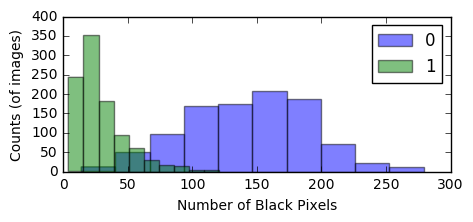

In [49]:
overlap0 = [np.sum(zeros[i, :, :]*zeros[i, :, :].T) for i in range(1000)]
overlap1 = [np.sum(ones[i, :, :]*ones[i, :, :].T) for i in range(1000)]
fig, ax = plt.subplots(figsize=(5, 2))
ax.hist(overlap0, alpha = 0.5), ax.hist(overlap1, alpha = 0.5)
plt.legend(['0', '1']); plt.xlabel('Number of Black Pixels'); plt.ylabel('Counts (of images)');